In [1]:
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2
import logging

In [82]:
import torch
from nowcasting.hko.dataloader import HKOIterator
from nowcasting.config import cfg
from nowcasting.utils import *
import numpy as np
from nowcasting.helpers.visualization import save_hko_gif, save_hko_movie
import os
import os.path as osp
import cv2
import numpy as np
from tqdm import tqdm_notebook
from nowcasting.models.convLSTM import ConvLSTM
from nowcasting.models.encoder import Encoder
from nowcasting.models.forecaster import Forecaster
from nowcasting.models.model import EF
from nowcasting.hko.evaluation import HKOEvaluation

## 阈值与像素值对应

In [31]:
cfg.HKO.EVALUATION.THRESHOLDS

array([ 0.5,  2. ,  5. , 10. , 30. ])

In [32]:
rainfall_to_pixel(cfg.HKO.EVALUATION.THRESHOLDS)

array([0.3282531 , 0.46242647, 0.55111025, 0.61819693, 0.72452681])

In [33]:
rainfall_to_pixel(cfg.HKO.EVALUATION.THRESHOLDS)*255

array([ 83.70454162, 117.91875085, 140.53311305, 157.64021766,
       184.75433697])

像素值是 255 的对应不到 rainfall.

In [64]:
pixel_to_rainfall(255)

inf

In [63]:
rainfall_to_pixel(0)

-inf

In [65]:
pixel_to_rainfall(0)

0.01682826752826454

In [68]:
np.sum((counts/np.sum(counts))[:83])

0.96231525816964009335

## 统计像素值

In [52]:
counts = np.zeros(256, dtype=np.float128)
file_list = []
for root, dirs, files in os.walk(cfg.HKO_PNG_PATH):
    for file_name in files:
        p = osp.join(root, file_name)
        file_list.append(p)

In [56]:
for p in tqdm_notebook(file_list):
    im = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2GRAY)
    label, count = np.unique(im, return_counts=True)
    counts[label] += count

In [58]:
counts/np.sum(counts)

array([9.36386464e-01, 0.00000000e+00, 5.59860839e-05, 0.00000000e+00,
       6.75041933e-05, 8.97365411e-05, 0.00000000e+00, 1.01720315e-04,
       0.00000000e+00, 1.13979783e-04, 0.00000000e+00, 1.30917343e-04,
       0.00000000e+00, 1.62465662e-04, 0.00000000e+00, 1.81989294e-04,
       1.90858420e-04, 0.00000000e+00, 2.02702843e-04, 0.00000000e+00,
       2.15276597e-04, 0.00000000e+00, 2.21572461e-04, 0.00000000e+00,
       2.40491959e-04, 0.00000000e+00, 2.62481183e-04, 2.73846527e-04,
       0.00000000e+00, 2.77543871e-04, 0.00000000e+00, 2.86072046e-04,
       0.00000000e+00, 2.98116932e-04, 0.00000000e+00, 3.12413019e-04,
       3.26999993e-04, 0.00000000e+00, 3.46416843e-04, 0.00000000e+00,
       3.56746985e-04, 0.00000000e+00, 3.80316851e-04, 0.00000000e+00,
       4.18590815e-04, 0.00000000e+00, 4.35467861e-04, 4.43758224e-04,
       0.00000000e+00, 4.75989171e-04, 0.00000000e+00, 4.91327837e-04,
       0.00000000e+00, 5.11612352e-04, 0.00000000e+00, 5.38648786e-04,
      

In [70]:
np.save('pixel_counts', counts)

## 验证数据加载

In [3]:
valid_hko_iter = HKOIterator(pd_path=cfg.HKO_PD.RAINY_VALID,
                                 sample_mode="sequent",
                                 seq_len=25,
                                 stride=5)

In [7]:
valid_hko_iter.reset()
valid_time = 0
while not valid_hko_iter.use_up:
    valid_batch, valid_mask, sample_datetimes, new_start =\
        valid_hko_iter.sample(batch_size=1)
    if valid_batch.shape[1] == 0:
        break
    valid_time += 1

In [8]:
valid_hko_iter.use_up

True

In [10]:
valid_hko_iter.reset()
valid_batch, valid_mask, sample_datetimes, new_start =\
    valid_hko_iter.sample(batch_size=1)

In [11]:
valid_batch.shape

(25, 1, 1, 480, 480)

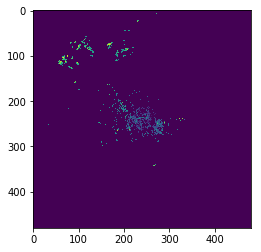

In [18]:
import matplotlib.pyplot as plt
plt.imshow(valid_batch[0, 0, 0, ...]/255.0)

## 存储视频

In [21]:
save_hko_movie(valid_batch[:, 0, 0, :, :],
                       sample_datetimes[0],
                       valid_mask[:, 0, 0, :, :],
                       masked=True,
                       save_path='1' + '.mp4')

Moviepy - Building video 1.mp4.
Moviepy - Writing video 1.mp4

Moviepy - Done !
Moviepy - video ready 1.mp4


### 计算性能

In [76]:
encoder_params = [
    [
        OrderedDict({'conv1_leaky_1': [1, 8, 7, 5, 1]}),
        OrderedDict({'conv2_leaky_1': [64, 192, 5, 3, 1]}),
        OrderedDict({'conv3_leaky_1': [192, 192, 3, 2, 1]}),
    ],

    [
        ConvLSTM(8, 64, 3),
        ConvLSTM(192, 192, 3),
        ConvLSTM(192, 192, 3)
    ]
]


encoder = Encoder(encoder_params[0], encoder_params[1]).to(cfg.GLOBAL.DEVICE)

forecaster_params = [
    [
        OrderedDict({'deconv1_leaky_1': [192, 192, 4, 2, 1]}),
        OrderedDict({'deconv2_leaky_1': [192, 64, 5, 3, 1]}),
        OrderedDict({
            'deconv3_leaky_1': [64, 8, 7, 5, 1],
            'conv3_leaky_2': [8, 8, 3, 1, 1],
            'conv3_3': [8, 1, 1, 1, 0] # 忘了删除激活函数了，妈的
            # 忘了卷积层，分类
        }),
    ],

    [
        ConvLSTM(192, 192, 3),
        ConvLSTM(192, 192, 3),
        ConvLSTM(64, 64, 3)
    ]
]

forecaster = Forecaster(forecaster_params[0], forecaster_params[1]).to(cfg.GLOBAL.DEVICE)

encoder_forecaster = EF(encoder, forecaster).to(cfg.GLOBAL.DEVICE)

In [79]:
valid_hko_iter = HKOIterator(pd_path=cfg.HKO_PD.RAINY_VALID,
                                 sample_mode="sequent",
                                 seq_len=25,
                                 stride=5)

valid_batch, valid_mask, sample_datetimes, new_start =\
        valid_hko_iter.sample(batch_size=2)

valid_batch = torch.from_numpy(valid_batch.astype(np.float32)).to(cfg.GLOBAL.DEVICE) / 255.0
valid_data = valid_batch[:cfg.HKO.BENCHMARK.IN_LEN, ...]
valid_label = valid_batch[cfg.HKO.BENCHMARK.IN_LEN:cfg.HKO.BENCHMARK.IN_LEN + cfg.HKO.BENCHMARK.OUT_LEN, ...]
mask = torch.from_numpy(valid_mask[cfg.HKO.BENCHMARK.IN_LEN:cfg.HKO.BENCHMARK.IN_LEN + cfg.HKO.BENCHMARK.OUT_LEN, ...].astype(int)).to(cfg.GLOBAL.DEVICE)
output = encoder_forecaster(valid_data)

In [80]:
output.size()

torch.Size([20, 2, 1, 480, 480])

In [84]:
evaluater = HKOEvaluation(seq_len=cfg.HKO.BENCHMARK.OUT_LEN, use_central=False)

In [85]:
valid_label_numpy = valid_label.cpu().numpy()
output_numpy = np.clip(output.detach().cpu().numpy(), 0.0, 1.0)
evaluater.update(valid_label_numpy, output_numpy, mask.cpu().numpy())

In [87]:
_, _, valid_csi, valid_hss, _, valid_mse, valid_mae, valid_balanced_mse, valid_balanced_mae, _ = evaluater.calculate_stat()

In [100]:
valid_csi.shape, valid_hss.shape 

((20, 5), (20, 5))

In [101]:
valid_mse.shape, valid_mae.shape, valid_balanced_mse.shape, valid_balanced_mae.shape

((20,), (20,), (20,), (20,))

In [102]:
valid_csi

array([[ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., nan]])

In [103]:
np.nan_to_num(valid_csi)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])